***Can only retrieve up to 1000 data points from Flipside API***

In [403]:
import pandas as pd
import numpy as np 
import requests
import json
import time
from flipside import Flipside
import os
import traceback
from dotenv import load_dotenv
import datetime as dt
import plotly.express as px
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from prophet import Prophet
from dash import Dash, html, dcc, Input, Output, State, callback
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from dash import dash_table



from sql.sql_scripts import mints, sales, eth_price

In [176]:
load_dotenv()

True

In [177]:
pd.options.display.float_format = '{:,.2f}'.format


In [178]:
opensea_api_key = os.getenv('opensea_api_key')
print(opensea_api_key)

c0c9ef9df89042059cee12e5ca9197e9


***Listing Data***

In [179]:
def fetch_listings(api_key, delay_between_requests=1):
    base_url = "https://api.opensea.io/api/v2/listings/collection/3dns-powered-domains/all"
    headers = {
        "accept": "application/json",
        "x-api-key": api_key
    }
    params = {"limit": 100} 

    listings = []
    page_count = 0

    while True:
        response = requests.get(base_url, headers=headers, params=params)
        if response.status_code == 200:
            data = response.json()
            fetched_listings = data.get("listings", [])
            listings.extend(fetched_listings)
            page_count += 1
            
            # Extract and print the cursor
            next_cursor = data.get("next")
            print(f"Page {page_count}, Cursor: {next_cursor}, Listings Fetched: {len(fetched_listings)}")
            
            if next_cursor:
                params['next'] = next_cursor  # Update the 'next' parameter for the next request
            else:
                break  # No more pages to fetch
                
            # Implementing delay
            time.sleep(delay_between_requests)
            
        else:
            print(f"Failed to fetch data: {response.status_code}")
            break

    print(f"Total pages fetched: {page_count}")
    print(f"Total listings fetched: {len(listings)}")
    
    df = pd.DataFrame(listings)
    return df

***Descriptions***

In [180]:
def save_last_identifier(identifier):
    with open("last_identifier.txt", "w") as file:
        file.write(identifier)

def load_last_identifier():
    try:
        with open("last_identifier.txt", "r") as file:
            return file.read().strip()
    except FileNotFoundError:
        return None

In [181]:
def fetch_all_descriptions(api_key, delay_between_requests=1):
    base_url = "https://api.opensea.io/api/v2/collection/3dns-powered-domains/nfts"
    headers = {
        "accept": "application/json",
        "x-api-key": api_key
    }
    params = {"limit": 100}

    all_descriptions = []

    page_count = 0
    last_identifier = load_last_identifier()

    while True:
        if last_identifier:
            params['last_identifier'] = last_identifier

        response = requests.get(base_url, headers=headers, params=params)
        if response.status_code == 200:
            data = response.json()
            fetched_descriptions = data.get("nfts", [])
            
            if not fetched_descriptions:
                break

            # Process only name and identifier for each description
            for description in fetched_descriptions:
                processed_description = {
                    "name": description.get('name'),
                    "identifier": description.get('identifier')
                }
                all_descriptions.append(processed_description)
            
            # Update the last_identifier to the latest one fetched
            last_identifier = fetched_descriptions[-1].get('identifier')
            save_last_identifier(last_identifier)
            
            page_count += 1
            next_cursor = data.get("next")
            print(f"Page {page_count}, Cursor: {next_cursor} Descriptions Fetched: {len(fetched_descriptions)}, total fetched: {len(all_descriptions)}")
            
            if next_cursor:
                params['next'] = next_cursor
            else:
                break  # No more pages to fetch

            time.sleep(delay_between_requests)
        else:
            print(f"Failed to fetch data: {response.status_code}")
            break

    print(f"Total pages fetched: {page_count}, Total descriptions fetched: {len(all_descriptions)}")
    
    # Save the processed descriptions to a file
    df = pd.DataFrame(all_descriptions)
    return df

***Events***

In [182]:
import json
import os

def save_last_timestamp(event_type, timestamp):
    data = {}
    if os.path.exists("last_timestamps.json"):
        with open("last_timestamps.json", "r") as file:
            data = json.load(file)
    data[event_type] = timestamp
    with open("last_timestamps.json", "w") as file:
        json.dump(data, file)

def load_last_timestamp(event_type):
    if os.path.exists("last_timestamps.json"):
        with open("last_timestamps.json", "r") as file:
            data = json.load(file)
        return data.get(event_type, None)
    return None

In [183]:
def fetch_event_type(api_key, event_type, all_events, params, headers):
    base_url = f"https://api.opensea.io/api/v2/events/collection/3dns-powered-domains"
    params['event_type'] = event_type
    
    # Load the last timestamp/identifier
    last_timestamp = load_last_timestamp(event_type)
    if last_timestamp:
        params['occurred_after'] = last_timestamp
    
    page_count = 0
    while True:
        response = requests.get(base_url, headers=headers, params=params)
        if response.status_code == 200:
            data = response.json()
            fetched_events = data.get("asset_events", [])
            all_events.extend(fetched_events)
            
            if fetched_events:
                # Update the last timestamp/identifier to the latest one fetched
                last_event_time = fetched_events[-1].get("created_date")
                save_last_timestamp(event_type, last_event_time)
            
            page_count += 1
            next_cursor = data.get("next")
            print(f"Fetching {event_type}: Page {page_count}, Events Fetched: {len(fetched_events)}, Total Events: {len(all_events)}, next cursor: {next_cursor}")
            
            if next_cursor:
                params['next'] = next_cursor
            else:
                break  # No more pages to fetch

            time.sleep(1)  # Delay between requests
        else:
            print(f"Failed to fetch {event_type} data: HTTP {response.status_code}, Response: {response.text}")
            break

def fetch_all_events(api_key):
    headers = {
        "accept": "application/json",
        "x-api-key": api_key
    }
    params = {
        "limit": 50  # Adjust the limit as needed
    }

    all_events = []

    # Fetch listings
    fetch_event_type(api_key, "listing", all_events, params.copy(), headers)

    # Fetch sales
    fetch_event_type(api_key, "sale", all_events, params.copy(), headers)

    # Save the fetched events to a DataFrame
    print(f"Total events fetched: {len(all_events)}")
    df = pd.DataFrame(all_events)
    return df 

***Flipside Data***

In [184]:
flipside_api_key = os.getenv("FLIPSIDE_API_KEY")
flipside = Flipside(flipside_api_key, "https://api-v2.flipsidecrypto.xyz")

In [185]:
def flipside_api_results(query):
  query_result_set = flipside.query(query)
  # what page are we starting on?
  current_page_number = 1

  # How many records do we want to return in the page?
  page_size = 1000

  # set total pages to 1 higher than the `current_page_number` until
  # we receive the total pages from `get_query_results` given the 
  # provided `page_size` (total_pages is dynamically determined by the API 
  # based on the `page_size` you provide)

  total_pages = 2


  # we'll store all the page results in `all_rows`
  all_rows = []

  while current_page_number <= total_pages:
    results = flipside.get_query_results(
      query_result_set.query_id,
      page_number=current_page_number,
      page_size=page_size
    )

    total_pages = results.page.totalPages
    if results.records:
        all_rows = all_rows + results.records
    
    current_page_number += 1

  return pd.DataFrame(all_rows)

query_result_set = flipside.query(sales)

# what page are we starting on?
current_page_number = 1

# How many records do we want to return in the page?
page_size = 1000

# set total pages to 1 higher than the `current_page_number` until
# we receive the total pages from `get_query_results` given the 
# provided `page_size` (total_pages is dynamically determined by the API 
# based on the `page_size` you provide)
total_pages = 2

# we'll store all the page results in `all_rows`
all_rows = []

while current_page_number <= total_pages:
  results = flipside.get_query_results(
    query_result_set.query_id,
    page_number=current_page_number,
    page_size=page_size
  )

  total_pages = results.page.totalPages
  if results.records:
      all_rows = all_rows + results.records
  
  current_page_number += 1

mints_df = pd.DataFrame(all_rows)



def createQueryRun(sql):
    url = "https://api-v2.flipsidecrypto.xyz/json-rpc"
    payload = json.dumps({
        "jsonrpc": "2.0",
        "method": "createQueryRun",
        "params": [{
            "resultTTLHours": 1,
            "maxAgeMinutes": 0,
            "sql": sql,
            "tags": {"source": "streamlit-demo", "env": "test"},
            "dataSource": "snowflake-default",
            "dataProvider": "flipside"
        }],
        "id": 1
    })
    headers = {'Content-Type': 'application/json', 'x-api-key': flipside_api_key}
    response = requests.post(url, headers=headers, data=payload)
    response_data = response.json()

    # Check for errors in the response
    if 'error' in response_data:
        error_message = response_data['error'].get('message', 'No error message provided')
        print("Full response data for debugging:", response_data)
        raise Exception(f"Error: {error_message}")

    if 'result' not in response_data or 'queryRun' not in response_data['result'] or 'id' not in response_data['result']['queryRun']:
        print("Unexpected response structure:", response_data)
        raise Exception("Unexpected response structure")

    query_run_id = response_data['result']['queryRun']['id']
    return response_data, query_run_id

#@st.cache_data(ttl='15m')
def getQueryResults(query_run_id, attempts=10, delay=30):
    url = "https://api-v2.flipsidecrypto.xyz/json-rpc"
    payload = json.dumps({
        "jsonrpc": "2.0",
        "method": "getQueryRunResults",
        "params": [{"queryRunId": query_run_id, "format": "json", "page": {"number": 1, "size": 10000}}],
        "id": 1
    })
    headers = {'Content-Type': 'application/json', 'x-api-key': flipside_api_key}

    for attempt in range(attempts):
        response = requests.post(url, headers=headers, data=payload)
        resp_json = response.json()
        if 'result' in resp_json:
            return resp_json  # Data is ready
        elif 'error' in resp_json and 'message' in resp_json['error'] and 'not yet completed' in resp_json['error']['message']:
            time.sleep(delay)  # Wait for a bit before retrying
        else:
            print("Unexpected response or error:", resp_json)
            break  # Break on unexpected error
    return None  # Return None if data isn't ready after all attempts


def retrieve_flipside_data(query):
    try:
        response_data, q_id = createQueryRun(query)
        if q_id:
            df_json = getQueryResults(q_id)
            if df_json:
                df = pd.DataFrame(df_json['result']['rows'])
                print(f"data fetched: {df.head()}")
                return df
            else:
                print('Failed to get results')
        else:
            print('Failed to create query run')
    except Exception as e:
        print(f"Error in fetching data: {e}")
        traceback.print_exc()
    

***Data Retrieval/Processing***

In [186]:
mint_df = flipside_api_results(mints)

In [187]:
mint_df

,day,tokenid,tx_hash,__row_index
0,2024-07-07T18:00:00.000Z,"105,524,492,317,869,381,078,152,749,075,908,174...",0xae65535fffa118255a3b20f779398f23eef9beb93fee...,0
1,2024-07-07T18:00:00.000Z,"105,524,492,317,869,381,078,152,749,075,908,174...",0xae65535fffa118255a3b20f779398f23eef9beb93fee...,1
2,2024-07-07T14:00:00.000Z,"10,355,336,948,949,831,006,775,035,890,746,600,...",0x6613c9605e27646889908d3b2bc57f7b05f72ba7ea95...,2
3,2024-07-07T14:00:00.000Z,"10,355,336,948,949,831,006,775,035,890,746,600,...",0x6613c9605e27646889908d3b2bc57f7b05f72ba7ea95...,3
4,2024-07-07T10:00:00.000Z,"110,922,447,138,034,312,511,773,049,614,694,612...",0x1072718e7f7390623b7fc9b2f3422344d487ee6bc208...,4
...,...,...,...,...
32729,2023-10-04T02:00:00.000Z,"73,079,797,870,479,156,483,046,577,349,357,812,...",0x981dd9c93e0419a227128b7ee95c620e7dbc88fe92e8...,32729
32730,2023-10-04T02:00:00.000Z,"97,049,678,982,547,095,836,606,605,282,336,114,...",0xd7ece008b97cad61f02396def394751c3fa9a4c2844a...,32730
32731,2023-10-04T02:00:00.000Z,"97,049,678,982,547,095,836,606,605,282,336,114,...",0xd7ece008b97cad61f02396def394751c3fa9a4c2844a...,32731
32732,2023-10-04T02:00:00.000Z,"77,875,674,875,312,083,922,572,966,307,662,148,...",0x64f70f46174e15001ff109ce325f9d0e0d7a571a22ed...,32732


In [188]:
sales_df = flipside_api_results(sales)

In [189]:
eth_usd_df = flipside_api_results(eth_price)

In [190]:
events_df = fetch_all_events(api_key= opensea_api_key)

Fetching listing: Page 1, Events Fetched: 50, Total Events: 50, next cursor: LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTA3LTAyKzIzJTNBMjglM0EwNS42MTI2NzEmLWV2ZW50X3R5cGU9Y3JlYXRlZCYtcGs9MjM5ODYxNTY0ODQ=
Fetching listing: Page 2, Events Fetched: 50, Total Events: 100, next cursor: LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTA2LTI3KzE5JTNBNDIlM0E1OS44OTcxNDUmLWV2ZW50X3R5cGU9Y3JlYXRlZCYtcGs9MjM4Mzc5Njc1OTc=
Fetching listing: Page 3, Events Fetched: 50, Total Events: 150, next cursor: LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTA2LTIzKzE4JTNBNDUlM0EyNS40MTYwMTMmLWV2ZW50X3R5cGU9Y3JlYXRlZCYtcGs9MjM3MjIyMjAzNjA=
Fetching listing: Page 4, Events Fetched: 50, Total Events: 200, next cursor: LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTA2LTIyKzE0JTNBMTclM0E0Ny44NDc4NTkmLWV2ZW50X3R5cGU9Y3JlYXRlZCYtcGs9MjM2ODgxOTYyMTg=
Fetching listing: Page 5, Events Fetched: 50, Total Events: 250, next cursor: LWV2ZW50X3RpbWVzdGFtcD0yMDI0LTA2LTE5KzIwJTNBNTUlM0EyMi40MDg1NDAmLWV2ZW50X3R5cGU9Y3JlYXRlZCYtcGs9MjM2MTUyNzg4NTU=
Fetching listing: Page 6, Events Fetched: 50, 

In [191]:
descriptions_df = fetch_all_descriptions(api_key= opensea_api_key)

Page 1, Cursor: LXBrPTE4OTkxMzAwNTQ= Descriptions Fetched: 100, total fetched: 100
Page 2, Cursor: LXBrPTE4OTIwNjk0OTc= Descriptions Fetched: 100, total fetched: 200
Page 3, Cursor: LXBrPTE4ODExOTQ0NjU= Descriptions Fetched: 100, total fetched: 300
Page 4, Cursor: LXBrPTE4NzE1ODkyNTU= Descriptions Fetched: 100, total fetched: 400
Page 5, Cursor: LXBrPTE4NjQ5OTIzODE= Descriptions Fetched: 100, total fetched: 500
Page 6, Cursor: LXBrPTE4NTI4Mzc5NzE= Descriptions Fetched: 100, total fetched: 600
Page 7, Cursor: LXBrPTE4NDQzNzc3MDA= Descriptions Fetched: 100, total fetched: 700
Page 8, Cursor: LXBrPTE4Mzc0MjA0Nzc= Descriptions Fetched: 100, total fetched: 800
Page 9, Cursor: LXBrPTE4MzQ5MTY3MzI= Descriptions Fetched: 100, total fetched: 900
Page 10, Cursor: LXBrPTE4MzIwNjQ3MjQ= Descriptions Fetched: 100, total fetched: 1000
Page 11, Cursor: LXBrPTE4MjgyNjM1MTk= Descriptions Fetched: 100, total fetched: 1100
Page 12, Cursor: LXBrPTE4MjYwNjAwNTA= Descriptions Fetched: 100, total fetched: 120

In [192]:
listings_df = fetch_listings(api_key= opensea_api_key, delay_between_requests=1)

Page 1, Cursor: cGs9MTc0ODI3MTAyMDYmY3JlYXRlZF9kYXRlPTIwMjQtMDMtMDYrMDMlM0E1MiUzQTMyLjU4ODA4Nw==, Listings Fetched: 100
Page 2, Cursor: cGs9MTg2NDAxMDQxODMmY3JlYXRlZF9kYXRlPTIwMjQtMDQtMjgrMDklM0E1MiUzQTAxLjAwNzE2MQ==, Listings Fetched: 100
Page 3, Cursor: cGs9MTg3OTI1MTI0NjEmY3JlYXRlZF9kYXRlPTIwMjQtMDUtMDQrMTUlM0E1NyUzQTA4LjEzMjQ4Nw==, Listings Fetched: 100
Page 4, Cursor: cGs9MTkzMjQ2MTYyMjQmY3JlYXRlZF9kYXRlPTIwMjQtMDUtMjYrMjAlM0EyMSUzQTI2LjQ5ODY0Mw==, Listings Fetched: 100
Page 5, Cursor: cGs9MTk3MjQzMDQ1MDAmY3JlYXRlZF9kYXRlPTIwMjQtMDYtMTMrMTAlM0EyNSUzQTE2LjQzOTMyOQ==, Listings Fetched: 100
Page 6, Cursor: cGs9MTk5MzMyMTQyNTgmY3JlYXRlZF9kYXRlPTIwMjQtMDYtMjIrMTUlM0ExMyUzQTEzLjY1NzI2OQ==, Listings Fetched: 100
Page 7, Cursor: None, Listings Fetched: 96
Total pages fetched: 7
Total listings fetched: 696


In [193]:
def unpack_protocol_data(row):
    protocol_data = row['protocol_data']
    parameters = protocol_data.get('parameters', {})
    consideration = parameters.get('consideration', [{}])
    offer = parameters.get('offer', [{}])
    price = row['price']['current']
    
    chain = row['chain']
    order_hash = row['order_hash']
    currency = price.get('currency')
    price_string = price.get('value')
    price_in_eth = float(price_string) / (10 ** price.get('decimals', 18))
    primary_recipient = consideration[0].get('recipient') if consideration else None
    identifier_or_criteria = offer[0].get('identifierOrCriteria') if offer else None
    start_time = parameters.get('startTime')
    end_time = parameters.get('endTime')
    
    return pd.Series([
        chain, order_hash, currency, price_string, price_in_eth, 
        primary_recipient, identifier_or_criteria, start_time, end_time
    ])

In [194]:
unpacked_columns = listings_df.apply(unpack_protocol_data, axis=1)
unpacked_columns.columns = [
    'chain', 'order_hash', 'currency', 'price_string', 'price_in_eth', 
    'primary_recipient', 'identifier_or_criteria', 'start_time', 'end_time'
]
listings_df = pd.concat([listings_df, unpacked_columns], axis=1)
listings_df = listings_df.drop(columns=['protocol_data'])


In [195]:
listings_df['identifier_or_criteria'] = listings_df['identifier_or_criteria'].astype(float)
listings_df.rename(columns={'identifier_or_criteria':'tokenid'}, inplace=True)

In [196]:
listings_df.drop(columns=['price_string','currency','primary_recipient','chain','price','protocol_address','type'], inplace=True)

In [197]:
descriptions_df.rename(columns={'identifier':'tokenid'}, inplace=True)

In [198]:
descriptions_df['tokenid'] = descriptions_df['tokenid'].astype(float)

In [199]:
listings_with_names = listings_df.merge(descriptions_df, how='left', on='tokenid')
box_listings = listings_with_names[listings_with_names['name'].str.endswith('.box')]
box_listings

,order_hash,order_hash,price_in_eth,tokenid,start_time,end_time,name
1,0x472882ed6ef6df3e646a968fe399a794cb2d80783c0d...,0x472882ed6ef6df3e646a968fe399a794cb2d80783c0d...,8.00,"103,348,240,472,784,936,049,086,084,648,101,639...",1705973310,1721694506,open.box
2,0x3040ad3f37193e684cb2baa0811d21cd345108df5a2a...,0x3040ad3f37193e684cb2baa0811d21cd345108df5a2a...,3.00,"102,295,845,026,135,496,883,892,522,779,159,999...",1706042993,1721767789,jewelry.box
3,0xb62518c46df32c07046a53f3df61112cc4460bc648ac...,0xb62518c46df32c07046a53f3df61112cc4460bc648ac...,3.00,"75,270,179,101,124,303,647,088,469,843,731,665,...",1706043120,1721767916,gay.box
4,0xe4c2e069a35f4b943e449d8e510f952ff3cb2fc133d3...,0xe4c2e069a35f4b943e449d8e510f952ff3cb2fc133d3...,8.00,"15,351,911,394,148,160,117,736,899,619,150,406,...",1706069852,1721791047,power.box
5,0x8bc67ab0f6355d8c78a317dee43dd93aad665ffa66d0...,0x8bc67ab0f6355d8c78a317dee43dd93aad665ffa66d0...,69.00,"92,045,738,473,223,622,079,151,157,139,670,821,...",1706083009,1721804202,dan.box
...,...,...,...,...,...,...,...
691,0x5b9231dba509bd04bf4a40cebed04061aec0bac17dd3...,0x5b9231dba509bd04bf4a40cebed04061aec0bac17dd3...,0.80,"61,445,275,927,213,011,434,826,616,454,840,224,...",1720344479,1720603559,ensvision.box
692,0xb6136385b048b5bdfad229bdaff05dfee3337ed18207...,0xb6136385b048b5bdfad229bdaff05dfee3337ed18207...,0.12,"112,995,818,248,598,233,060,911,981,365,146,698...",1720353519,1720612765,777777.box
693,0x64a15f62a417bb92386c03f2f661a365178a5f8661ea...,0x64a15f62a417bb92386c03f2f661a365178a5f8661ea...,1.90,"28,360,466,965,013,677,414,172,494,359,945,146,...",1720353825,1720443248,cypherpunk.box
694,0xbb3f335bb2739159bed3a98ff5e50329e0e955284664...,0xbb3f335bb2739159bed3a98ff5e50329e0e955284664...,3.00,"10,355,336,948,949,831,006,775,035,890,746,600,...",1720365963,1736263557,pov.box


In [200]:
events_df_copy = events_df.copy()
events_df_copy

,event_type,order_hash,order_type,chain,protocol_address,start_date,expiration_date,asset,quantity,maker,taker,payment,criteria,event_timestamp,is_private_listing,closing_date,nft,seller,buyer,transaction
0,order,0x6a2fd6abf225a6de63bfd5236118b3fcfc5c389ec68c...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,374,825.00","1,720,443,248.00",{'identifier': '283604669650136775214415072033...,1,0x9a93ae4f408a1e7d178650ca9f7ab2135c512eda,,"{'quantity': '500000000000000000', 'token_addr...",{},1720374830,False,NaN,NaN,NaN,NaN,NaN
1,order,0xbb3f335bb2739159bed3a98ff5e50329e0e955284664...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,365,963.00","1,736,263,557.00",{'identifier': '103553369489498314981934932873...,1,0x14c6a3fb0fa46a43d01dc7426d7c27cf8c71c10a,,"{'quantity': '3000000000000000000', 'token_add...",{},1720365981,False,NaN,NaN,NaN,NaN,NaN
2,order,0x64a15f62a417bb92386c03f2f661a365178a5f8661ea...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,353,825.00","1,720,443,248.00",{'identifier': '283604669650136775214415072033...,1,0x9a93ae4f408a1e7d178650ca9f7ab2135c512eda,,"{'quantity': '1900000000000000000', 'token_add...",{},1720353830,False,NaN,NaN,NaN,NaN,NaN
3,order,0xb6136385b048b5bdfad229bdaff05dfee3337ed18207...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,353,519.00","1,720,612,765.00",{'identifier': '112995818248598227413563035922...,1,0x9a93ae4f408a1e7d178650ca9f7ab2135c512eda,,"{'quantity': '123000000000000000', 'token_addr...",{},1720353524,False,NaN,NaN,NaN,NaN,NaN
4,order,0x5b9231dba509bd04bf4a40cebed04061aec0bac17dd3...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,344,479.00","1,720,603,559.00",{'identifier': '614452759272130136383164409549...,1,0x8699b8b6c1163f29f6ab153bf890c0214d2d4df4,,"{'quantity': '800000000000000000', 'token_addr...",{},1720344498,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2947,sale,0x8bde44f2d46537cf8d025cc498eaf7bdeadce3631f15...,NaN,optimism,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,NaN,NaN,NaN,1,NaN,NaN,"{'quantity': '1000000000000000', 'token_addres...",NaN,1706970257,NaN,"1,706,970,257.00",{'identifier': '260923785748676206958654735781...,0xcc0e0b9ebd4ce352f5a50b3ae77ea01202c284ee,0xc48a8ac51df7b71e500a5580b89e47ab26ca1472,0x60e952a8e0fa8d052791b2e4a22fd52eb3c759511e62...
2948,sale,0xc0547b5b8d575e3ba16b529ee2530a35c437bc75fa93...,NaN,optimism,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,NaN,NaN,NaN,1,NaN,NaN,"{'quantity': '110000000000000000', 'token_addr...",NaN,1706653465,NaN,"1,706,653,465.00",{'identifier': '566479911085778512201556021651...,0x240ad467a71210629d71d4de22ebde27951c83fc,0x82eb45562f991329ed2867f43fc60f0ba52c3dab,0x6672189deb7829838aabba20ddeb66a3cb5fee5b55a2...
2949,sale,0xff4b9bdd3f140f8211864ef34e0a07ea0a92eaf98f7d...,NaN,optimism,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,NaN,NaN,NaN,1,NaN,NaN,"{'quantity': '10000000000000000', 'token_addre...",NaN,1706203283,NaN,"1,706,203,283.00",{'identifier': '364706086468987072255605061503...,0x7b363822d744143d51c69b0757165c987a6e4ef4,0xe68e8cc7ff772b026c062b9cc28246676d044947,0xd8e71f4d52c43fa770b9aa7ad7d5cfb073f04c7495e0...
2950,sale,0x03188e15aaf9596307117e30355f6b2ac79665fbd1c2...,NaN,optimism,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,NaN,NaN,NaN,1,NaN,NaN,"{'quantity': '150000000000000000', 'token_addr...",NaN,1704080589,NaN,"1,704,080,589.00",{'identifier': '992340878683635895851755157396...,0x31b32020fb1bdf0228c58b80590f07b235f2b0ce,0x64233eaa064ef0d54ff1a963933d0d2d46ab5829,0x186d1ceacf620bab710d11cf928b79e5dd46790ff1d5...


In [201]:
bids = events_df_copy[events_df_copy['event_type'] == 'order']
sales = events_df_copy[events_df_copy['event_type'] == 'sale']

bids

,event_type,order_hash,order_type,chain,protocol_address,start_date,expiration_date,asset,quantity,maker,taker,payment,criteria,event_timestamp,is_private_listing,closing_date,nft,seller,buyer,transaction
0,order,0x6a2fd6abf225a6de63bfd5236118b3fcfc5c389ec68c...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,374,825.00","1,720,443,248.00",{'identifier': '283604669650136775214415072033...,1,0x9a93ae4f408a1e7d178650ca9f7ab2135c512eda,,"{'quantity': '500000000000000000', 'token_addr...",{},1720374830,False,NaN,NaN,NaN,NaN,NaN
1,order,0xbb3f335bb2739159bed3a98ff5e50329e0e955284664...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,365,963.00","1,736,263,557.00",{'identifier': '103553369489498314981934932873...,1,0x14c6a3fb0fa46a43d01dc7426d7c27cf8c71c10a,,"{'quantity': '3000000000000000000', 'token_add...",{},1720365981,False,NaN,NaN,NaN,NaN,NaN
2,order,0x64a15f62a417bb92386c03f2f661a365178a5f8661ea...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,353,825.00","1,720,443,248.00",{'identifier': '283604669650136775214415072033...,1,0x9a93ae4f408a1e7d178650ca9f7ab2135c512eda,,"{'quantity': '1900000000000000000', 'token_add...",{},1720353830,False,NaN,NaN,NaN,NaN,NaN
3,order,0xb6136385b048b5bdfad229bdaff05dfee3337ed18207...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,353,519.00","1,720,612,765.00",{'identifier': '112995818248598227413563035922...,1,0x9a93ae4f408a1e7d178650ca9f7ab2135c512eda,,"{'quantity': '123000000000000000', 'token_addr...",{},1720353524,False,NaN,NaN,NaN,NaN,NaN
4,order,0x5b9231dba509bd04bf4a40cebed04061aec0bac17dd3...,listing,optimism,0x0000000000000068f116a894984e2db1123eb395,"1,720,344,479.00","1,720,603,559.00",{'identifier': '614452759272130136383164409549...,1,0x8699b8b6c1163f29f6ab153bf890c0214d2d4df4,,"{'quantity': '800000000000000000', 'token_addr...",{},1720344498,False,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,order,0x3bbb21c5a1766b47ea91b2dafd73e7cb28198b41b3c6...,listing,optimism,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,"1,703,615,460.00","1,706,293,860.00",{'identifier': '596691372334868032834900148779...,1,0xec00481d13a4028e0b76b031cf5c863604cb2d4b,,"{'quantity': '3000000000000000000', 'token_add...",{},1703615466,False,NaN,NaN,NaN,NaN,NaN
2857,order,0xa2931b385c3bd5c237a44cc39a452e9f12499ba6cafd...,listing,optimism,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,"1,703,615,375.00","1,706,293,775.00",{'identifier': '178657174778441322562715723560...,1,0xec00481d13a4028e0b76b031cf5c863604cb2d4b,,"{'quantity': '3000000000000000000', 'token_add...",{},1703615382,False,NaN,NaN,NaN,NaN,NaN
2858,order,0x0fff804500518519b60164f5a10ef76e63da9ee77775...,listing,optimism,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,"1,703,615,237.00","1,706,293,637.00",{'identifier': '887409359338823895470224549460...,1,0x64233eaa064ef0d54ff1a963933d0d2d46ab5829,,"{'quantity': '3000000000000000000', 'token_add...",{},1703615249,False,NaN,NaN,NaN,NaN,NaN
2859,order,0x3e6ab1b4b98dd45a1cd97fc141659077293095161497...,listing,optimism,0x00000000000000adc04c56bf30ac9d3c0aaf14dc,"1,703,607,296.00","1,704,212,091.00",{'identifier': '117315147600270829665702926801...,1,0x7af4ca674c86ac74d15ae668ae7ffbe4f7ddafbf,,"{'quantity': '1000000000000000000', 'token_add...",{},1703607304,False,NaN,NaN,NaN,NaN,NaN


In [202]:
bids['identifier'] = bids['asset'].apply(lambda x: x.get('identifier') if isinstance(x, dict) else None)
sales['identifier'] = sales['nft'].apply(lambda x: x.get('identifier') if isinstance(x, dict) else None)

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\2668839905.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\2668839905.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [203]:
bids['identifier'] = bids['identifier'].astype(float)
bids.rename(columns={'identifier':'tokenid'}, inplace=True) 


C:\Users\brand\AppData\Local\Temp\ipykernel_12448\46667634.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\46667634.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [204]:
bids = bids.merge(descriptions_df, how='left', on='tokenid')

In [205]:
bids.columns

Index(['event_type', 'order_hash', 'order_type', 'chain', 'protocol_address',
       'start_date', 'expiration_date', 'asset', 'quantity', 'maker', 'taker',
       'payment', 'criteria', 'event_timestamp', 'is_private_listing',
       'closing_date', 'nft', 'seller', 'buyer', 'transaction', 'tokenid',
       'name'],
      dtype='object')

In [206]:
bids.drop(columns=['protocol_address','chain','maker','criteria','is_private_listing','closing_date','nft','seller','buyer'], inplace=True)

In [207]:
sales['identifier'] = sales['identifier'].astype(float)
sales.rename(columns={'identifier':'tokenid'}, inplace=True)


C:\Users\brand\AppData\Local\Temp\ipykernel_12448\3642358893.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\3642358893.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [208]:
sales = sales.merge(descriptions_df, how='left', on='tokenid')
sales.drop(columns=['order_type', 'chain','start_date','expiration_date','asset','maker','is_private_listing','protocol_address','criteria'], inplace=True)

In [209]:
bids

,event_type,order_hash,order_type,start_date,expiration_date,asset,quantity,taker,payment,event_timestamp,transaction,tokenid,name
0,order,0x6a2fd6abf225a6de63bfd5236118b3fcfc5c389ec68c...,listing,"1,720,374,825.00","1,720,443,248.00",{'identifier': '283604669650136775214415072033...,1,,"{'quantity': '500000000000000000', 'token_addr...",1720374830,NaN,"28,360,466,965,013,677,414,172,494,359,945,146,...",cypherpunk.box
1,order,0xbb3f335bb2739159bed3a98ff5e50329e0e955284664...,listing,"1,720,365,963.00","1,736,263,557.00",{'identifier': '103553369489498314981934932873...,1,,"{'quantity': '3000000000000000000', 'token_add...",1720365981,NaN,"10,355,336,948,949,831,006,775,035,890,746,600,...",pov.box
2,order,0x64a15f62a417bb92386c03f2f661a365178a5f8661ea...,listing,"1,720,353,825.00","1,720,443,248.00",{'identifier': '283604669650136775214415072033...,1,,"{'quantity': '1900000000000000000', 'token_add...",1720353830,NaN,"28,360,466,965,013,677,414,172,494,359,945,146,...",cypherpunk.box
3,order,0xb6136385b048b5bdfad229bdaff05dfee3337ed18207...,listing,"1,720,353,519.00","1,720,612,765.00",{'identifier': '112995818248598227413563035922...,1,,"{'quantity': '123000000000000000', 'token_addr...",1720353524,NaN,"112,995,818,248,598,233,060,911,981,365,146,698...",777777.box
4,order,0x5b9231dba509bd04bf4a40cebed04061aec0bac17dd3...,listing,"1,720,344,479.00","1,720,603,559.00",{'identifier': '614452759272130136383164409549...,1,,"{'quantity': '800000000000000000', 'token_addr...",1720344498,NaN,"61,445,275,927,213,011,434,826,616,454,840,224,...",ensvision.box
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2856,order,0x3bbb21c5a1766b47ea91b2dafd73e7cb28198b41b3c6...,listing,"1,703,615,460.00","1,706,293,860.00",{'identifier': '596691372334868032834900148779...,1,,"{'quantity': '3000000000000000000', 'token_add...",1703615466,NaN,"59,669,137,233,486,797,576,913,893,823,506,075,...",mintdomains.io
2857,order,0xa2931b385c3bd5c237a44cc39a452e9f12499ba6cafd...,listing,"1,703,615,375.00","1,706,293,775.00",{'identifier': '178657174778441322562715723560...,1,,"{'quantity': '3000000000000000000', 'token_add...",1703615382,NaN,"17,865,717,477,844,132,496,699,921,146,330,333,...",dnsloans.com
2858,order,0x0fff804500518519b60164f5a10ef76e63da9ee77775...,listing,"1,703,615,237.00","1,706,293,637.00",{'identifier': '887409359338823895470224549460...,1,,"{'quantity': '3000000000000000000', 'token_add...",1703615249,NaN,"8,874,093,593,388,239,065,001,647,753,652,567,1...",0ooo0ooo0.ooo
2859,order,0x3e6ab1b4b98dd45a1cd97fc141659077293095161497...,listing,"1,703,607,296.00","1,704,212,091.00",{'identifier': '117315147600270829665702926801...,1,,"{'quantity': '1000000000000000000', 'token_add...",1703607304,NaN,"11,731,514,760,027,082,503,362,540,473,080,970,...",tokentroopers.xyz


In [210]:
box_sales_os = sales[sales['name'].str.endswith('.box')]
box_bids_os = bids[bids['name'].str.endswith('.box')] 

In [211]:
box_bids_os.columns = [f'bid_{col}' if col != 'name' else col for col in box_bids_os.columns]

In [212]:
box_sales_os.columns = [f'sale_{col}' if col != 'name' else col for col in box_sales_os.columns]

In [213]:
box_bids_os

,bid_event_type,bid_order_hash,bid_order_type,bid_start_date,bid_expiration_date,bid_asset,bid_quantity,bid_taker,bid_payment,bid_event_timestamp,bid_transaction,bid_tokenid,name
0,order,0x6a2fd6abf225a6de63bfd5236118b3fcfc5c389ec68c...,listing,"1,720,374,825.00","1,720,443,248.00",{'identifier': '283604669650136775214415072033...,1,,"{'quantity': '500000000000000000', 'token_addr...",1720374830,NaN,"28,360,466,965,013,677,414,172,494,359,945,146,...",cypherpunk.box
1,order,0xbb3f335bb2739159bed3a98ff5e50329e0e955284664...,listing,"1,720,365,963.00","1,736,263,557.00",{'identifier': '103553369489498314981934932873...,1,,"{'quantity': '3000000000000000000', 'token_add...",1720365981,NaN,"10,355,336,948,949,831,006,775,035,890,746,600,...",pov.box
2,order,0x64a15f62a417bb92386c03f2f661a365178a5f8661ea...,listing,"1,720,353,825.00","1,720,443,248.00",{'identifier': '283604669650136775214415072033...,1,,"{'quantity': '1900000000000000000', 'token_add...",1720353830,NaN,"28,360,466,965,013,677,414,172,494,359,945,146,...",cypherpunk.box
3,order,0xb6136385b048b5bdfad229bdaff05dfee3337ed18207...,listing,"1,720,353,519.00","1,720,612,765.00",{'identifier': '112995818248598227413563035922...,1,,"{'quantity': '123000000000000000', 'token_addr...",1720353524,NaN,"112,995,818,248,598,233,060,911,981,365,146,698...",777777.box
4,order,0x5b9231dba509bd04bf4a40cebed04061aec0bac17dd3...,listing,"1,720,344,479.00","1,720,603,559.00",{'identifier': '614452759272130136383164409549...,1,,"{'quantity': '800000000000000000', 'token_addr...",1720344498,NaN,"61,445,275,927,213,011,434,826,616,454,840,224,...",ensvision.box
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2819,order,0x472882ed6ef6df3e646a968fe399a794cb2d80783c0d...,listing,"1,705,973,310.00","1,721,694,506.00",{'identifier': '103348240472784938693450072722...,1,,"{'quantity': '8000000000000000000', 'token_add...",1705973330,NaN,"103,348,240,472,784,936,049,086,084,648,101,639...",open.box
2820,order,0x9f91f3031bea58c65527094995a80c8ac04ec11cabc3...,listing,"1,705,951,814.00","1,706,211,009.00",{'identifier': '910130851175214067204502281907...,1,,"{'quantity': '9990000000000000000', 'token_add...",1705951959,NaN,"91,013,085,117,521,410,273,961,891,024,065,292,...",xxx.box
2822,order,0xf7eabd25103d87771cfa5b7ec1f833ff28b305e2e951...,listing,"1,705,880,300.00","1,706,485,096.00",{'identifier': '310600624953776604609951946603...,1,,"{'quantity': '18000000000000000000', 'token_ad...",1705880336,NaN,"31,060,062,495,377,660,754,331,643,768,291,496,...",88.box
2823,order,0x8a5a4f735475cfb1a1ad0d37ee3f6b550c731091ef1e...,listing,"1,705,876,048.00","1,721,600,844.00",{'identifier': '443446172444352102226461664950...,1,,"{'quantity': '88000000000000000000', 'token_ad...",1705876076,NaN,"44,344,617,244,435,210,889,725,244,831,655,211,...",o.box


In [214]:
box_listings_and_sales = pd.merge(box_bids_os, box_sales_os, how='inner', on='name')
box_listings_and_sales['bid_event_timestamp'] = pd.to_datetime(box_listings_and_sales['bid_event_timestamp'], unit='s')
box_listings_and_sales['sale_event_timestamp'] = pd.to_datetime(box_listings_and_sales['sale_event_timestamp'], unit='s')


In [215]:
filtered_box_listings_and_sales = box_listings_and_sales[box_listings_and_sales['sale_event_timestamp'] > box_listings_and_sales['bid_event_timestamp']]
filtered_box_listings_and_sales['time_diff'] = filtered_box_listings_and_sales['sale_event_timestamp'] - filtered_box_listings_and_sales['bid_event_timestamp']


C:\Users\brand\AppData\Local\Temp\ipykernel_12448\2210088090.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [216]:
avg_time_to_sell = filtered_box_listings_and_sales['time_diff'].mean()
print(avg_time_to_sell)

19 days 11:19:25.506097561


In [217]:
closest_listings = filtered_box_listings_and_sales.loc[filtered_box_listings_and_sales.groupby(['name', 'sale_event_timestamp'])['time_diff'].idxmin()]


In [218]:
closest_listings['sale_quantity'] = closest_listings['sale_payment'].apply(lambda x: int(x['quantity']) / 10**18)
closest_listings['listing_quantity'] = closest_listings['bid_payment'].apply(lambda x: int(x['quantity']) / 10**18)


In [219]:
closest_listings[['bid_event_timestamp','listing_quantity']].head()

,bid_event_timestamp,listing_quantity
33,2024-04-23 10:22:52,0.03
68,2024-02-12 18:32:17,0.04
51,2024-02-24 06:41:03,0.04
64,2024-02-19 23:52:15,0.04
56,2024-02-23 04:00:29,0.10


In [220]:
closest_listings['bid_event_timestamp'] = closest_listings['bid_event_timestamp'].dt.strftime('%Y-%m-%d %H:00:00')


In [221]:
closest_listings['sale_event_timestamp'] = closest_listings['sale_event_timestamp'].dt.strftime('%Y-%m-%d %H:00:00')

In [222]:
mint_df['tokenid'] = mint_df['tokenid'].astype(float)

In [223]:
mints_with_names = pd.merge(mint_df, descriptions_df, how='left', on='tokenid')

In [224]:
mints_with_names

,day,tokenid,tx_hash,__row_index,name
0,2024-07-07T18:00:00.000Z,"105,524,492,317,869,381,078,152,749,075,908,174...",0xae65535fffa118255a3b20f779398f23eef9beb93fee...,0,university.box
1,2024-07-07T18:00:00.000Z,"105,524,492,317,869,381,078,152,749,075,908,174...",0xae65535fffa118255a3b20f779398f23eef9beb93fee...,1,university.box
2,2024-07-07T14:00:00.000Z,"10,355,336,948,949,831,006,775,035,890,746,600,...",0x6613c9605e27646889908d3b2bc57f7b05f72ba7ea95...,2,pov.box
3,2024-07-07T14:00:00.000Z,"10,355,336,948,949,831,006,775,035,890,746,600,...",0x6613c9605e27646889908d3b2bc57f7b05f72ba7ea95...,3,pov.box
4,2024-07-07T10:00:00.000Z,"110,922,447,138,034,312,511,773,049,614,694,612...",0x1072718e7f7390623b7fc9b2f3422344d487ee6bc208...,4,patr0n.xyz
...,...,...,...,...,...
32729,2023-10-04T02:00:00.000Z,"73,079,797,870,479,156,483,046,577,349,357,812,...",0x981dd9c93e0419a227128b7ee95c620e7dbc88fe92e8...,32729,org
32730,2023-10-04T02:00:00.000Z,"97,049,678,982,547,095,836,606,605,282,336,114,...",0xd7ece008b97cad61f02396def394751c3fa9a4c2844a...,32730,net
32731,2023-10-04T02:00:00.000Z,"97,049,678,982,547,095,836,606,605,282,336,114,...",0xd7ece008b97cad61f02396def394751c3fa9a4c2844a...,32731,net
32732,2023-10-04T02:00:00.000Z,"77,875,674,875,312,083,922,572,966,307,662,148,...",0x64f70f46174e15001ff109ce325f9d0e0d7a571a22ed...,32732,com


In [225]:
mints_with_names_null = mints_with_names[mints_with_names.isnull().any(axis=1)]
print(list(mints_with_names_null['tx_hash']))

['0xb47db1490ab537cbbd227388a32567952c2bf27d5e55864a9415110f2af63ca7', '0xb47db1490ab537cbbd227388a32567952c2bf27d5e55864a9415110f2af63ca7', '0x62f6283e6459d7e2a19c818e515927d159daa57d08ff5b55c79141b7f28b94a3', '0x62f6283e6459d7e2a19c818e515927d159daa57d08ff5b55c79141b7f28b94a3', '0x1f172942f03578e445dfe20e5104a799c87a88a108d4cf095d96c8e841dc8a99', '0x1f172942f03578e445dfe20e5104a799c87a88a108d4cf095d96c8e841dc8a99']


In [226]:
mints_with_names.drop_duplicates('tokenid', inplace=True)

In [227]:
mints_with_names.drop(columns=['__row_index','tx_hash','tokenid'], inplace=True)

In [228]:
mints_with_names.set_index('day', inplace=True)

In [229]:
mints_with_names.index = pd.to_datetime(mints_with_names.index)
mints_with_names.dropna(inplace=True)

In [230]:
box_domains_mints = mints_with_names[mints_with_names['name'].str.endswith('.box')]


In [231]:
box_domains_mints

,name
day,
2024-07-07 18:00:00+00:00,university.box
2024-07-07 14:00:00+00:00,pov.box
2024-07-07 02:00:00+00:00,mt.box
2024-07-07 02:00:00+00:00,contract.box
2024-07-07 01:00:00+00:00,stable.box
...,...
2023-10-31 17:00:00+00:00,duncan.box
2023-10-26 14:00:00+00:00,intercap-dev.box
2023-10-24 19:00:00+00:00,s.box


In [232]:
daily_box_mints = box_domains_mints.resample('D').count()

C:\Users\brand\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



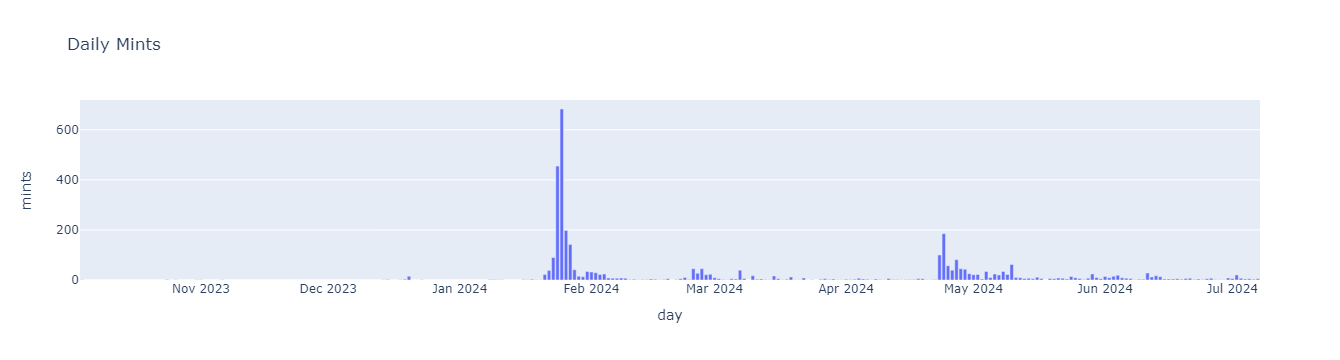

In [233]:
daily_box_mints.rename(columns={'name':'mints'}, inplace=True)
daily_box_mints_fig = px.bar(daily_box_mints, x=daily_box_mints.index, y='mints', title='Daily Mints')
daily_box_mints_fig.show()

In [234]:
total_box_mints = box_domains_mints.count().iloc[0]
total_box_mints

3607

In [235]:
sales_with_names = pd.merge(sales_df, descriptions_df, how='left', on='tokenid')

In [236]:
sales_with_names.drop_duplicates('tokenid', inplace=True)
sales_with_names.drop(columns=['__row_index','tx_hash','tokenid'], inplace=True)
sales_with_names.set_index('day', inplace=True)
sales_with_names.index = pd.to_datetime(sales_with_names.index)

In [237]:
box_domains_sales = sales_with_names[sales_with_names['name'].str.endswith('.box')]
box_domains_sales

,price,name
day,,
2024-04-17 18:00:00+00:00,0.01,mewtwo.box
2024-04-24 04:00:00+00:00,0.03,0000.box
2024-04-25 21:00:00+00:00,0.10,express.box
2024-04-27 16:00:00+00:00,10.00,vm.box
2024-04-27 00:00:00+00:00,0.37,jane.box
2024-04-28 07:00:00+00:00,0.10,good.box
2024-04-28 01:00:00+00:00,0.07,man.box
2024-05-07 22:00:00+00:00,0.06,onyx.box
2024-02-03 22:00:00+00:00,0.01,696.box


In [238]:
eth_usd_df.set_index('day', inplace=True)
eth_usd_df.index = pd.to_datetime(eth_usd_df.index)
eth_usd_df.drop(columns=['__row_index'], inplace=True)

In [239]:
eth_usd_df.rename(columns={'price':'eth_usd'}, inplace=True)

In [240]:
box_listings['start_time'] = pd.to_datetime(box_listings['start_time'], unit='s').dt.strftime('%Y-%m-%d %H:00:00')
box_listings['end_time'] = pd.to_datetime(box_listings['end_time'], unit='s').dt.strftime('%Y-%m-%d %H:00:00')

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\1480011625.py:1: FutureWarning:

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To retain the old behavior, explicitly cast ints or floats to numeric type before calling to_datetime.

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\1480011625.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\1480011625.py:2: FutureWarning:

The behavior of 'to_datetime' with 'unit' when parsing strings is deprecated. In a future version, strings will be parsed as datetime strings, matching the behavior without a 'unit'. To reta

In [241]:
eth_usd_df_copy = eth_usd_df.reset_index().copy()
eth_usd_df_copy.rename(columns={'day':'start_time'}, inplace=True)

In [242]:
eth_usd_df_copy['start_time'] = pd.to_datetime(eth_usd_df_copy['start_time']).dt.tz_localize(None)

In [243]:
box_listings['start_time'] = pd.to_datetime(box_listings['start_time']) 

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\1939952577.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [244]:
eth_usd_df_copy_2 = eth_usd_df_copy.copy()
eth_usd_df_copy_2.rename(columns={'start_time':'bid_event_timestamp', 'eth_usd':'eth_usd_bid'}, inplace=True)

In [245]:
eth_usd_df_copy_3 = eth_usd_df_copy.copy()
eth_usd_df_copy_3.rename(columns={'start_time':'sale_event_timestamp', 'eth_usd':'eth_usd_sale'}, inplace=True)

In [246]:
closest_listings

,bid_event_type,bid_order_hash,bid_order_type,bid_start_date,bid_expiration_date,bid_asset,bid_quantity,bid_taker,bid_payment,bid_event_timestamp,...,sale_payment,sale_event_timestamp,sale_closing_date,sale_nft,sale_seller,sale_buyer,sale_transaction,sale_tokenid,time_diff,listing_quantity
33,order,0x9c93a66cfda75ee4644448fb58cae06eb0812df451fb...,listing,"1,713,867,753.00","1,716,459,753.00",{'identifier': '703498242317845484567858628589...,1,,"{'quantity': '29000000000000000', 'token_addre...",2024-04-23 10:00:00,...,"{'quantity': '29000000000000000', 'token_addre...",2024-04-24 04:00:00,"1,713,934,467.00",{'identifier': '703498242317845484567858628589...,0x0c289ec5d7fac13ecba85a404f144dfe461f6757,0x9f65a2c44f7d41da4a66cdb7a11cfc4d5c6a5701,0xa10ad4838da88ca27edb13cc4ad94b4f26d8c703a2e9...,"7,034,982,423,178,454,817,470,894,177,061,768,9...",0 days 18:31:35,0.03
68,order,0xae0f0119039a0405216a385824cce1662a72011f2bb4...,listing,"1,707,762,730.00","1,710,268,210.00",{'identifier': '496962274766683276127777586567...,1,,"{'quantity': '40000000000000000', 'token_addre...",2024-02-12 18:00:00,...,"{'quantity': '40000000000000000', 'token_addre...",2024-02-25 02:00:00,"1,708,829,917.00",{'identifier': '496962274766683276127777586567...,0x3276e82ebb1b4b9f01ab9286ed6bcc6603e368e2,0xf408bee3443d0397e2c1cde588fb060ac657006f,0x8f45ee1a6d326905bbc9ef018536ccda79a0b00543ad...,"49,696,227,476,668,324,726,036,518,805,210,474,...",12 days 08:26:20,0.04
51,order,0xb383acd8e244e0278b99e153f7a27d1a153020241595...,listing,"1,708,756,857.00","1,709,361,579.00",{'identifier': '255496510243247998967394616710...,1,,"{'quantity': '35000000000000000', 'token_addre...",2024-02-24 06:00:00,...,"{'quantity': '35000000000000000', 'token_addre...",2024-02-25 03:00:00,"1,708,832,065.00",{'identifier': '255496510243247998967394616710...,0xb7d8d3e6733e9e19887821e787297025a4fc93d3,0x9af5d20a9dffd92448dc0337b0900f3b48541de3,0x5285add55012e02f6d0705c017af6880a18b78777810...,"25,549,651,024,324,800,143,018,812,772,741,840,...",0 days 20:53:22,0.04
64,order,0x7c5dcfc329b68cf30adc1ae560f86b333ea00ac3c2d1...,listing,"1,708,386,727.00","1,710,888,605.00",{'identifier': '902676801938279802203143854774...,1,,"{'quantity': '40000000000000000', 'token_addre...",2024-02-19 23:00:00,...,"{'quantity': '40000000000000000', 'token_addre...",2024-02-22 04:00:00,"1,708,574,565.00",{'identifier': '902676801938279802203143854774...,0x6053904b1643182f235dd8f1a91e851662d93d35,0xa014bf15f0a6e208218c98c31f05338c45e4b010,0xcf386a26aae0dfebb8664c8d2c6590f67927d7aa4f7a...,"90,267,680,193,827,982,430,960,140,548,436,305,...",2 days 04:10:30,0.04
56,order,0x8a94cdc0c83ea1ba671a7b9bc041b3d39c32d31d7a71...,listing,"1,708,660,825.00","1,722,938,201.00",{'identifier': '110858464559300831902144923932...,1,,"{'quantity': '100000000000000000', 'token_addr...",2024-02-23 04:00:00,...,"{'quantity': '100000000000000000', 'token_addr...",2024-02-25 07:00:00,"1,708,846,421.00",{'identifier': '110858464559300831902144923932...,0x13918a208337f54005b8533b9d76d5b6e87303bb,0x27157c32c014598c7d743d8731e238ab151f2c65,0x77237a2ec2b775870ec09fc10310d399c80319a9b87e...,"110,858,464,559,300,825,990,569,710,147,236,992...",2 days 03:33:12,0.10
53,order,0x07afcb596b64f4420b0ffcf4bf57f171a6712d05e9ce...,listing,"1,708,746,396.00","1,724,471,192.00",{'identifier': '602749672470407216249937792665...,1,,"{'quantity': '70000000000000000', 'token_addre...",2024-02-24 03:00:00,...,"{'quantity': '70000000000000000', 'token_addre...",2024-02-25 03:00:00,"1,708,831,745.00",{'identifier': '602749672470407216249937792665...,0x4cfd50f62df880cccd5e6d489e9ea3039819aad1,0xf408bee3443d0397e2c1cde588fb060ac657006f,0x41efe31d90b0c7d45d028a1811d3beacd5e13ca768fe...,"60,274,967,247,040,719,711,675,361,166,867,087,...",0 days 23:42:22,0.07
52,order,0x36b9584c47a8999f3372488715cea97af37bcb61f248...,listing,"1,708,746,463.00","1,724,471,257.00",{'identifier': '200543934089042259451502567419...,1,,"{'quantity': '70000000000000000', 'toke

In [247]:
closest_listings['bid_event_timestamp'] = pd.to_datetime(closest_listings['bid_event_timestamp'])
closest_listings['sale_event_timestamp'] = pd.to_datetime(closest_listings['sale_event_timestamp'])

In [248]:
closest_listings = closest_listings.merge(eth_usd_df_copy_2, how='left', on='bid_event_timestamp')

In [249]:
closest_listings = closest_listings.merge(eth_usd_df_copy_3, how='left', on='sale_event_timestamp')

In [250]:
closest_listings['sale_usd'] = closest_listings['sale_quantity'] * closest_listings['eth_usd_sale']
closest_listings['list_usd'] = closest_listings['listing_quantity'] * closest_listings['eth_usd_bid']

In [251]:
closest_listings['percent_change'] = (closest_listings['sale_usd'] - closest_listings['list_usd']) / closest_listings['list_usd'] * 100

In [252]:
listing_price_to_sale_avg_pct_change = closest_listings['percent_change'].mean()
print(listing_price_to_sale_avg_pct_change)

-14.673687659116787


In [253]:

box_listings = box_listings.merge(eth_usd_df_copy, how='left', on='start_time') 

In [254]:
box_listings.drop(columns=['order_hash'], inplace=True)

In [255]:
box_listings['price_in_usd_start_time'] = box_listings['price_in_eth'] * box_listings['eth_usd']

In [256]:
box_listings.set_index('start_time', inplace=True)
box_listings_max_daily = box_listings['price_in_usd_start_time'].resample('D').max()

In [257]:
box_listings_num_daily = box_listings['name'].resample('D').count()
total_box_listings = box_listings_num_daily.sum()
total_box_listings

513

In [258]:
box_listings_num_daily

start_time
2024-01-23     3
2024-01-24    11
2024-01-25    11
2024-01-26     6
2024-01-27     4
              ..
2024-07-03     0
2024-07-04     8
2024-07-05     2
2024-07-06     8
2024-07-07     9
Freq: D, Name: name, Length: 167, dtype: int64

In [259]:
box_listings_min_daily = box_listings['price_in_usd_start_time'].resample('D').min()
box_listings_avg_daily = box_listings['price_in_usd_start_time'].resample('D').mean()

In [260]:
box_listings_max_daily.fillna(0, inplace=True)
box_listings_min_daily.fillna(0, inplace=True)
box_listings_avg_daily.fillna(0, inplace=True)

In [261]:
box_listing_data = pd.merge(box_listings_num_daily.to_frame('listings'), box_listings_max_daily.to_frame('max_price'), left_index=True,
                            right_index=True, how='inner')

In [262]:
box_listing_data = box_listing_data.merge(box_listings_min_daily.to_frame('min_price'), left_index=True,
                                          right_index=True, how='inner')

box_listing_data = box_listing_data.merge(box_listings_avg_daily.to_frame('avg_price'), left_index=True,
                                          right_index=True, how='inner')

In [263]:
box_listing_data

,listings,max_price,min_price,avg_price
start_time,,,,
2024-01-23,3,"18,508.01","6,582.45","10,557.64"
2024-01-24,11,"931,166.04","3,349.20","160,128.32"
2024-01-25,11,"2,206,503.58",660.15,"882,610.90"
2024-01-26,6,"665,376.23","4,478.13","162,767.74"
2024-01-27,4,"1,590,895.35","680,521.15","946,259.95"
...,...,...,...,...
2024-07-03,0,0.00,0.00,0.00
2024-07-04,8,"19,408.38",960.69,"4,183.43"
2024-07-05,2,"14,571.00","8,581.74","11,576.37"


In [264]:
monthly_listings = box_listings['name'].resample('M').count()
monthly_listings

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\1847853540.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



start_time
2024-01-31     36
2024-02-29     17
2024-03-31     11
2024-04-30     94
2024-05-31    145
2024-06-30    178
2024-07-31     32
Freq: ME, Name: name, dtype: int64

In [265]:
def monthly_listings_growth_rate(listings):
    previous_month = listings.shift(1)
    growth_rate = ((listings - previous_month) / previous_month) * 100
    return growth_rate

In [266]:
listings_growth_rate = monthly_listings_growth_rate(monthly_listings)


In [267]:
listings_growth_rate.dropna(inplace=True)
listings_growth_rate

start_time
2024-02-29   -52.78
2024-03-31   -35.29
2024-04-30   754.55
2024-05-31    54.26
2024-06-30    22.76
2024-07-31   -82.02
Freq: ME, Name: name, dtype: float64

In [268]:
box_domains_sales = box_domains_sales.merge(eth_usd_df, left_index=True, right_index=True, how='left')

In [269]:
box_domains_sales['price_usd'] = box_domains_sales['price'] * box_domains_sales['eth_usd']
box_domains_sales.rename(columns={'price':'price_eth'}, inplace=True)

In [270]:
box_domains_sales.drop(columns=['eth_usd'], inplace=True)


In [271]:
box_domains_sales.sort_index(inplace=True)
box_domains_mints.sort_index(inplace=True)

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\3245620862.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [272]:
box_domains_sales = box_domains_sales[['name', 'price_usd','price_eth']]


In [273]:
box_domains_sales

,name,price_usd,price_eth
day,,,
2024-02-03 22:00:00+00:00,696.box,33.09,0.01
2024-02-05 04:00:00+00:00,song.box,45.60,0.02
2024-02-10 19:00:00+00:00,to.box,96.97,0.04
2024-02-20 12:00:00+00:00,uae.box,203.19,0.07
2024-02-22 04:00:00+00:00,08.box,116.74,0.04
2024-02-24 04:00:00+00:00,404.box,203.68,0.07
2024-02-25 02:00:00+00:00,010.box,119.08,0.04
2024-02-25 03:00:00+00:00,70.box,269.17,0.09
2024-02-25 03:00:00+00:00,40.box,209.36,0.07


In [274]:
max_eth_sale = box_domains_sales['price_eth'].max()
max_usd_sale = box_domains_sales['price_usd'].max()

# Retrieve the corresponding timestamps
max_eth_sale_row = box_domains_sales.loc[box_domains_sales['price_eth'].idxmax()]
max_usd_sale_row = box_domains_sales.loc[box_domains_sales['price_usd'].idxmax()]

# Display the results
print(f"Maximum sale: \n {max_eth_sale_row}")


Maximum sale: 
 name           vm.box
price_usd   31,481.47
price_eth       10.00
Name: 2024-04-27 16:00:00+00:00, dtype: object


In [275]:
total_box_sales = box_domains_sales['name'].count()
print(f'total .box domain sales as of {dt.datetime.today()} : {total_box_sales}')

total .box domain sales as of 2024-07-07 14:25:35.831019 : 21


In [276]:
daily_box_sales = box_domains_sales['name'].resample('D').count()
daily_box_sales

day
2024-02-03 00:00:00+00:00    1
2024-02-04 00:00:00+00:00    0
2024-02-05 00:00:00+00:00    1
2024-02-06 00:00:00+00:00    0
2024-02-07 00:00:00+00:00    0
                            ..
2024-05-03 00:00:00+00:00    0
2024-05-04 00:00:00+00:00    0
2024-05-05 00:00:00+00:00    0
2024-05-06 00:00:00+00:00    0
2024-05-07 00:00:00+00:00    1
Freq: D, Name: name, Length: 95, dtype: int64

In [277]:
daily_box_vol = box_domains_sales['price_usd'].resample('D').sum()
cumulative_box_vol = daily_box_vol.cumsum()
cumulative_box_vol

day
2024-02-03 00:00:00+00:00       33.09
2024-02-04 00:00:00+00:00       33.09
2024-02-05 00:00:00+00:00       78.69
2024-02-06 00:00:00+00:00       78.69
2024-02-07 00:00:00+00:00       78.69
                               ...   
2024-05-03 00:00:00+00:00   35,720.31
2024-05-04 00:00:00+00:00   35,720.31
2024-05-05 00:00:00+00:00   35,720.31
2024-05-06 00:00:00+00:00   35,720.31
2024-05-07 00:00:00+00:00   35,888.14
Freq: D, Name: price_usd, Length: 95, dtype: float64

C:\Users\brand\anaconda3\lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



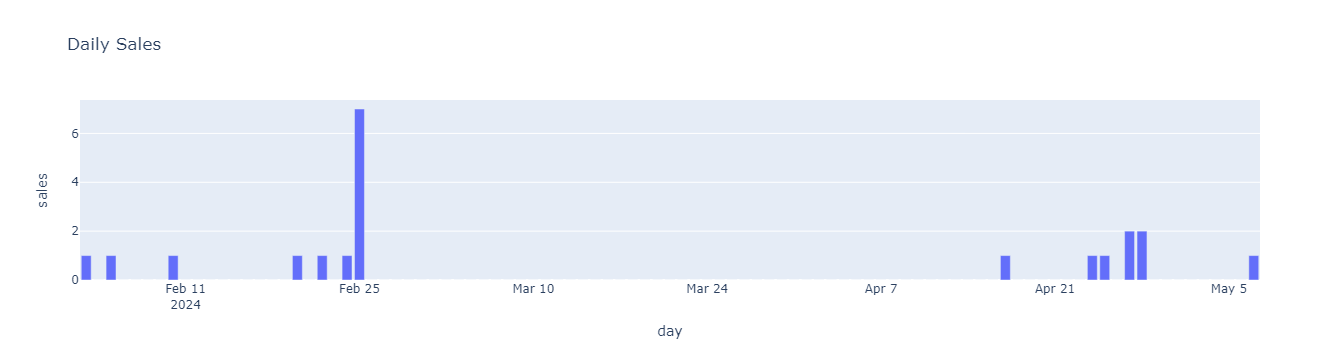

In [278]:
daily_box_sales_fig = px.bar(daily_box_sales.to_frame('sales'), x=daily_box_sales.index, y='sales', title='Daily Sales')
daily_box_sales_fig.show()

In [279]:
latest_box_domains_sales = box_domains_sales.iloc[-10:] 
latest_box_domains_sales

,name,price_usd,price_eth
day,,,
2024-02-25 03:00:00+00:00,015.box,104.68,0.04
2024-02-25 07:00:00+00:00,38.box,301.73,0.10
2024-04-17 18:00:00+00:00,mewtwo.box,29.61,0.01
2024-04-24 04:00:00+00:00,0000.box,93.92,0.03
2024-04-25 21:00:00+00:00,express.box,317.33,0.10
2024-04-27 00:00:00+00:00,jane.box,"1,151.71",0.37
2024-04-27 16:00:00+00:00,vm.box,"31,481.47",10.00
2024-04-28 01:00:00+00:00,man.box,224.60,0.07
2024-04-28 07:00:00+00:00,good.box,314.61,0.10


In [280]:
latest_box_domains_mints = box_domains_mints.iloc[-10:]
latest_box_domains_mints

,name
day,
2024-07-05 16:00:00+00:00,seismic.box
2024-07-05 20:00:00+00:00,kawaii.box
2024-07-06 17:00:00+00:00,yoel.box
2024-07-06 18:00:00+00:00,flohr.box
2024-07-06 21:00:00+00:00,humidor.box
2024-07-07 01:00:00+00:00,stable.box
2024-07-07 02:00:00+00:00,contract.box
2024-07-07 02:00:00+00:00,mt.box
2024-07-07 14:00:00+00:00,pov.box


In [281]:
cumulative_box_mints = daily_box_mints.cumsum()
cumulative_box_mints

,mints
day,
2023-10-04 00:00:00+00:00,1
2023-10-05 00:00:00+00:00,1
2023-10-06 00:00:00+00:00,1
2023-10-07 00:00:00+00:00,1
2023-10-08 00:00:00+00:00,1
...,...
2024-07-03 00:00:00+00:00,3590
2024-07-04 00:00:00+00:00,3594
2024-07-05 00:00:00+00:00,3599


In [282]:
cumulative_box_sales = daily_box_sales.cumsum()
cumulative_box_sales

day
2024-02-03 00:00:00+00:00     1
2024-02-04 00:00:00+00:00     1
2024-02-05 00:00:00+00:00     2
2024-02-06 00:00:00+00:00     2
2024-02-07 00:00:00+00:00     2
                             ..
2024-05-03 00:00:00+00:00    20
2024-05-04 00:00:00+00:00    20
2024-05-05 00:00:00+00:00    20
2024-05-06 00:00:00+00:00    20
2024-05-07 00:00:00+00:00    21
Freq: D, Name: name, Length: 95, dtype: int64

In [283]:
monthly_max_sold = box_domains_sales['price_usd'].resample('M').max()
monthly_min_sold = box_domains_sales['price_usd'].resample('M').min()
monthly_avg_sold = box_domains_sales['price_usd'].resample('M').mean()
monthly_volume_usd = box_domains_sales['price_usd'].resample('M').sum()

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\547997385.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\547997385.py:2: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\547997385.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\547997385.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [284]:
monthly_max_sold.fillna(0, inplace=True)
monthly_min_sold.fillna(0, inplace=True)
monthly_avg_sold.fillna(0, inplace=True)
monthly_volume_usd.fillna(0, inplace=True)

In [341]:
monthly_box_sales_metrics = pd.merge(monthly_max_sold.to_frame('max_price'), monthly_min_sold.to_frame('min_price'), left_index=True, right_index=True, how='inner')

In [342]:
monthly_box_sales_metrics = monthly_box_sales_metrics.merge(monthly_avg_sold.to_frame('avg_price'), left_index=True, right_index=True, how='inner')

In [343]:
monthly_box_sales_metrics = monthly_box_sales_metrics.merge(monthly_volume_usd.to_frame('volume_usd'), left_index=True, right_index=True, how='inner')

In [344]:
monthly_box_sales_metrics

,max_price,min_price,avg_price,volume_usd
day,,,,
2024-02-29 00:00:00+00:00,301.73,33.09,162.08,"2,107.05"
2024-03-31 00:00:00+00:00,0.00,0.00,0.00,0.00
2024-04-30 00:00:00+00:00,"31,481.47",29.61,"4,801.89","33,613.26"
2024-05-31 00:00:00+00:00,167.83,167.83,167.83,167.83


In [288]:
daily_sales_metrics = pd.merge(cumulative_box_sales.to_frame('cumulative_sales'), daily_box_sales.to_frame('daily_sales'), 
                               left_index=True, right_index=True, how='left')

In [289]:
daily_sales_metrics = daily_sales_metrics.merge(daily_box_vol.to_frame('vol_usd'), left_index=True, right_index=True, how='inner')
daily_sales_metrics = daily_sales_metrics.merge(cumulative_box_vol.to_frame('cumulative_vol'), left_index=True, right_index=True, how='inner')

In [290]:
daily_sales_metrics

,cumulative_sales,daily_sales,vol_usd,cumulative_vol
day,,,,
2024-02-03 00:00:00+00:00,1,1,33.09,33.09
2024-02-04 00:00:00+00:00,1,0,0.00,33.09
2024-02-05 00:00:00+00:00,2,1,45.60,78.69
2024-02-06 00:00:00+00:00,2,0,0.00,78.69
2024-02-07 00:00:00+00:00,2,0,0.00,78.69
...,...,...,...,...
2024-05-03 00:00:00+00:00,20,0,0.00,"35,720.31"
2024-05-04 00:00:00+00:00,20,0,0.00,"35,720.31"
2024-05-05 00:00:00+00:00,20,0,0.00,"35,720.31"


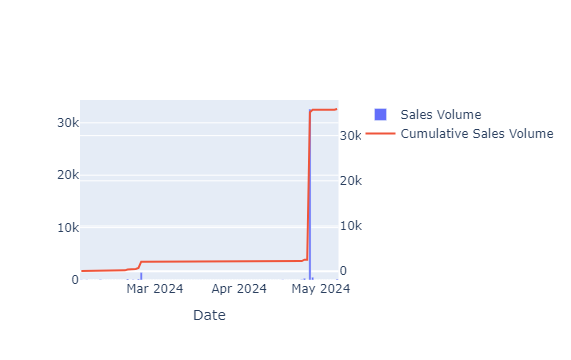

In [391]:
daily_vol_fig = make_subplots(specs=[[{"secondary_y": True}]])

daily_vol_fig.add_trace(
    go.Bar(
        x=daily_sales_metrics.index,
        y=daily_sales_metrics['vol_usd'],
        name='Sales Volume'
    ),
    secondary_y=False
)

daily_vol_fig.add_trace(
    go.Scatter(
        x=daily_sales_metrics.index,
        y=daily_sales_metrics['cumulative_vol'],
        name='Cumulative Sales Volume',
        mode='lines'
    ),
    secondary_y=True
)

daily_vol_fig.update_xaxes(title_text="Date")

daily_vol_fig.show()


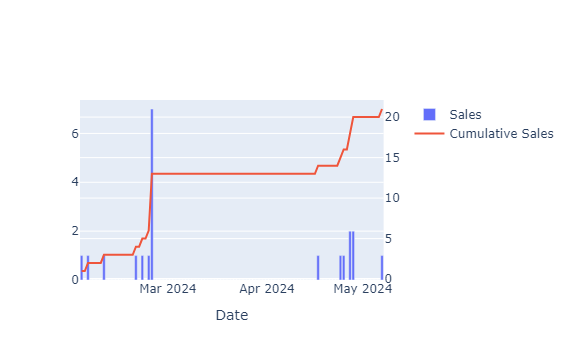

In [392]:
daily_sales_fig = make_subplots(specs=[[{"secondary_y": True}]])

daily_sales_fig.add_trace(
    go.Bar(
        x=daily_sales_metrics.index,
        y=daily_sales_metrics['daily_sales'],
        name='Sales'
    ),
    secondary_y=False
)

daily_sales_fig.add_trace(
    go.Scatter(
        x=daily_sales_metrics.index,
        y=daily_sales_metrics['cumulative_sales'],
        name='Cumulative Sales',
        mode='lines'
    ),
    secondary_y=True
)

daily_sales_fig.update_xaxes(title_text="Date")

daily_sales_fig.show()


In [291]:
monthly_listings = monthly_listings.to_frame('listings')


In [292]:
monthly_listings

,listings
start_time,
2024-01-31,36
2024-02-29,17
2024-03-31,11
2024-04-30,94
2024-05-31,145
2024-06-30,178
2024-07-31,32


In [293]:
monthly_sales = box_domains_sales['name'].resample('M').count()
monthly_sales = monthly_sales.reset_index()
monthly_sales['day'] = pd.to_datetime(monthly_sales['day']).dt.strftime('%Y-%m-%d')
monthly_sales.set_index('day', inplace=True)

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\2388482189.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [294]:
monthly_sales

,name
day,
2024-02-29,13
2024-03-31,0
2024-04-30,7
2024-05-31,1


In [295]:
monthly_listings.index

DatetimeIndex(['2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', name='start_time', freq='ME')

In [296]:
monthly_sales.index = pd.to_datetime(monthly_sales.index)

In [297]:
monthly_sales_reindexed = monthly_sales.reindex(monthly_listings.index).fillna(0)
monthly_sales_reindexed


,name
start_time,
2024-01-31,0.00
2024-02-29,13.00
2024-03-31,0.00
2024-04-30,7.00
2024-05-31,1.00
2024-06-30,0.00
2024-07-31,0.00


In [298]:
monthly_listings['sales'] = monthly_sales_reindexed['name']

In [299]:
monthly_listings

,listings,sales
start_time,,
2024-01-31,36,0.00
2024-02-29,17,13.00
2024-03-31,11,0.00
2024-04-30,94,7.00
2024-05-31,145,1.00
2024-06-30,178,0.00
2024-07-31,32,0.00


In [300]:
monthly_listings['listings_to_sales_ratio'] = monthly_listings['listings'] / monthly_listings['sales']
monthly_listings['listings_to_sales_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)

monthly_listings

C:\Users\brand\AppData\Local\Temp\ipykernel_12448\3641184892.py:2: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





,listings,sales,listings_to_sales_ratio
start_time,,,
2024-01-31,36,0.00,0.00
2024-02-29,17,13.00,1.31
2024-03-31,11,0.00,0.00
2024-04-30,94,7.00,13.43
2024-05-31,145,1.00,145.00
2024-06-30,178,0.00,0.00
2024-07-31,32,0.00,0.00


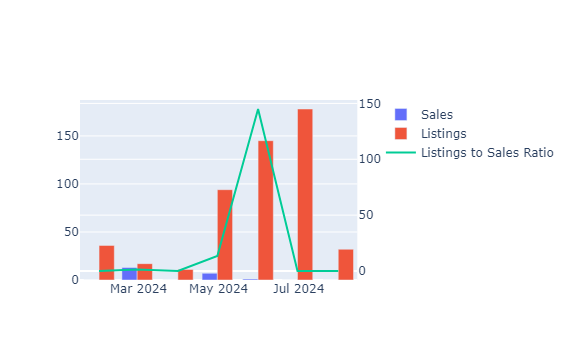

In [357]:
listing_to_sales_fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add bar chart for sales
listing_to_sales_fig.add_trace(
    go.Bar(
        x=monthly_listings.index,
        y=monthly_listings['sales'],
        name='Sales'
    ),
    secondary_y=False
)

listing_to_sales_fig.add_trace(
    go.Bar(
        x=monthly_listings.index,
        y=monthly_listings['listings'],
        name='Listings'
    ),
    secondary_y=False
)

# Add line chart for cumulative sales
listing_to_sales_fig.add_trace(
    go.Scatter(
        x=monthly_listings.index,
        y=monthly_listings['listings_to_sales_ratio'],
        name='Listings to Sales Ratio',
        mode='lines'
    ),
    secondary_y=True
)

listing_to_sales_fig.show()


In [301]:
monthly_mints = box_domains_mints.resample('M').count()
monthly_mints.reset_index(inplace=True)
monthly_mints['day'] = pd.to_datetime(monthly_mints['day']).dt.strftime('%Y-%m-%d') 
print(monthly_mints)

          day  name
0  2023-10-31     5
1  2023-11-30     2
2  2023-12-31    23
3  2024-01-31  1745
4  2024-02-29   349
5  2024-03-31   162
6  2024-04-30   636
7  2024-05-31   414
8  2024-06-30   221
9  2024-07-31    50


C:\Users\brand\AppData\Local\Temp\ipykernel_12448\2186263740.py:1: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [302]:
monthly_mints.set_index('day', inplace=True)


In [303]:
monthly_mints.index = pd.to_datetime(monthly_mints.index) 
monthly_mints.index

DatetimeIndex(['2023-10-31', '2023-11-30', '2023-12-31', '2024-01-31',
               '2024-02-29', '2024-03-31', '2024-04-30', '2024-05-31',
               '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', name='day', freq=None)

In [304]:
monthly_sales_reindexed.index

DatetimeIndex(['2024-01-31', '2024-02-29', '2024-03-31', '2024-04-30',
               '2024-05-31', '2024-06-30', '2024-07-31'],
              dtype='datetime64[ns]', name='start_time', freq='ME')

In [305]:
monthly_mints['sales'] = monthly_sales_reindexed['name'] 
monthly_mints.fillna(0, inplace=True)
monthly_mints['mint_to_sales_ratio'] = monthly_mints['name'] / monthly_mints['sales'] 
monthly_mints['mint_to_sales_ratio'].replace([float('inf'), -float('inf')], 0, inplace=True)
monthly_mints.rename(columns={'name':'mints'}, inplace=True)


C:\Users\brand\AppData\Local\Temp\ipykernel_12448\760772224.py:4: FutureWarning:

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.





In [306]:
monthly_mints

,mints,sales,mint_to_sales_ratio
day,,,
2023-10-31,5,0.00,0.00
2023-11-30,2,0.00,0.00
2023-12-31,23,0.00,0.00
2024-01-31,1745,0.00,0.00
2024-02-29,349,13.00,26.85
2024-03-31,162,0.00,0.00
2024-04-30,636,7.00,90.86
2024-05-31,414,1.00,414.00
2024-06-30,221,0.00,0.00


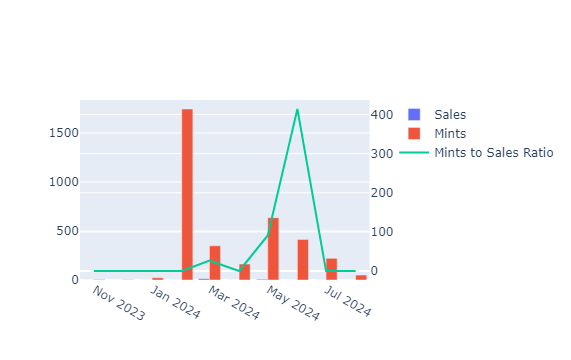

In [358]:
mint_to_sales_fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add bar chart for sales
mint_to_sales_fig.add_trace(
    go.Bar(
        x=monthly_mints.index,
        y=monthly_mints['sales'],
        name='Sales'
    ),
    secondary_y=False
)

mint_to_sales_fig.add_trace(
    go.Bar(
        x=monthly_mints.index,
        y=monthly_mints['mints'],
        name='Mints'
    ),
    secondary_y=False
)

# Add line chart for cumulative sales
mint_to_sales_fig.add_trace(
    go.Scatter(
        x=monthly_mints.index,
        y=monthly_mints['mint_to_sales_ratio'],
        name='Mints to Sales Ratio',
        mode='lines'
    ),
    secondary_y=True
)

mint_to_sales_fig.show()


In [307]:
cumulative_listings_to_sales = total_box_listings / total_box_sales
print(cumulative_listings_to_sales)

24.428571428571427


In [308]:
cumulative_mint_to_sales = total_box_mints / total_box_sales
print(cumulative_mint_to_sales)

171.76190476190476


In [309]:
import os
print(os.getcwd())


C:\Users\brand\Projects\box_domains


***Box Domains Valuation Model***

**Data Processing**

domain_path = 'E:/Projects/box_app/data/domain-name-sales.tsv'  
domain_data = pd.read_csv(domain_path, delimiter='\t')

In [310]:
domain_path = 'data/domain-name-sales.tsv'  
domain_data = pd.read_csv(domain_path, delimiter='\t')


In [311]:
domain_data.set_index('date', inplace=True)
domain_data = domain_data.drop(columns=['venue'])
domain_data.sort_index(inplace=True)

In [312]:
domain_data.index = pd.to_datetime(domain_data.index)
domain_data

,domain,price
date,,
1999-04-01,altavista.com,3250000
1999-04-01,bingo.com,1100000
1999-11-01,fly.com,1500000
1999-12-01,autos.com,2200000
1999-12-01,england.com,2000000
...,...,...
2021-01-01,yes.movie,253
2021-01-01,yopal.com,405
2021-01-01,yougraph.com,1161


In [313]:
domain_data['domain_length'] = domain_data['domain'].apply(len)
domain_data['num_vowels'] = domain_data['domain'].apply(lambda x: sum([1 for char in x if char in 'aeiou']))
domain_data['num_consonants'] = domain_data['domain'].apply(lambda x: sum([1 for char in x if char.isalpha() and char not in 'aeiou']))
domain_data['tld'] = domain_data['domain'].apply(lambda x: x.split('.')[-1])  # Extract TLD


In [314]:
domain_data

,domain,price,domain_length,num_vowels,num_consonants,tld
date,,,,,,
1999-04-01,altavista.com,3250000,13,5,7,com
1999-04-01,bingo.com,1100000,9,3,5,com
1999-11-01,fly.com,1500000,7,1,5,com
1999-12-01,autos.com,2200000,9,4,4,com
1999-12-01,england.com,2000000,11,3,7,com
...,...,...,...,...,...,...
2021-01-01,yes.movie,253,9,4,4,movie
2021-01-01,yopal.com,405,9,3,5,com
2021-01-01,yougraph.com,1161,12,4,7,com


In [315]:
box_domains_sales.columns

Index(['name', 'price_usd', 'price_eth'], dtype='object')

In [316]:
filtered_box = box_domains_sales.drop(columns=['price_eth'])
filtered_box.rename(columns={'name':'domain', 'price_usd':'price'}, inplace=True)


In [317]:
filtered_box['domain_length'] = filtered_box['domain'].apply(len)
filtered_box['num_vowels'] = filtered_box['domain'].apply(lambda x: sum([1 for char in x if char in 'aeiou']))
filtered_box['num_consonants'] = filtered_box['domain'].apply(lambda x: sum([1 for char in x if char.isalpha() and char not in 'aeiou']))
filtered_box['tld'] = filtered_box['domain'].apply(lambda x: x.split('.')[-1])  # Extract TLD


In [318]:
filtered_box.index = filtered_box.index.strftime('%Y-%m-%d')

In [319]:
filtered_box

,domain,price,domain_length,num_vowels,num_consonants,tld
day,,,,,,
2024-02-03,696.box,33.09,7,1,2,box
2024-02-05,song.box,45.60,8,2,5,box
2024-02-10,to.box,96.97,6,2,3,box
2024-02-20,uae.box,203.19,7,4,2,box
2024-02-22,08.box,116.74,6,1,2,box
2024-02-24,404.box,203.68,7,1,2,box
2024-02-25,010.box,119.08,7,1,2,box
2024-02-25,70.box,269.17,6,1,2,box
2024-02-25,40.box,209.36,6,1,2,box


In [320]:
features = ['domain_length', 'num_vowels', 'num_consonants', 'tld']
X = domain_data[features]
y = domain_data['price']

In [321]:
# Preprocess categorical data (TLD) and handle missing values
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), ['domain_length', 'num_vowels', 'num_consonants']),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), ['tld'])
    ]
)

# Create a pipeline with Ridge regression
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'regressor__alpha': [0.1, 1.0, 10.0, 100.0, 1000.0]
}

In [322]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Ridge Regression**

In [323]:
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Predict and evaluate
y_pred = best_model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Best Alpha: {grid_search.best_params_["regressor__alpha"]}')
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

Best Alpha: 1000.0
MAE: 2705.025532330721
MSE: 2852191402.3517637
R²: 0.00039259991875073563


**Random Forest Regressor**

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=200, max_depth=20, min_samples_split=5, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

**XGBoost**

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

**LightGBM**

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LGBMRegressor(n_estimators=200, max_depth=5, learning_rate=0.1, random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

**Cat Boost**

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', CatBoostRegressor(iterations=200, depth=5, learning_rate=0.1, random_state=42, verbose=0))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

**Prophet**

from sklearn.base import BaseEstimator, TransformerMixin

class ProphetRegressor(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.model = Prophet()
        self.fitted_model = None

    def fit(self, X, y=None):
        df = pd.DataFrame({'ds': X.squeeze(), 'y': y})
        self.fitted_model = self.model.fit(df)
        return self

    def predict(self, X):
        future = pd.DataFrame({'ds': X.squeeze()})
        forecast = self.fitted_model.predict(future)
        return forecast['yhat'].values

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', ProphetRegressor())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



**Best Model**

In [327]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=1000.0))  # Set the best alpha value from grid search
])

In [328]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')

MAE: 2705.025532330721
MSE: 2852191402.3517637
R²: 0.00039259991875073563


In [329]:
filtered_box

,domain,price,domain_length,num_vowels,num_consonants,tld
day,,,,,,
2024-02-03,696.box,33.09,7,1,2,box
2024-02-05,song.box,45.60,8,2,5,box
2024-02-10,to.box,96.97,6,2,3,box
2024-02-20,uae.box,203.19,7,4,2,box
2024-02-22,08.box,116.74,6,1,2,box
2024-02-24,404.box,203.68,7,1,2,box
2024-02-25,010.box,119.08,7,1,2,box
2024-02-25,70.box,269.17,6,1,2,box
2024-02-25,40.box,209.36,6,1,2,box


In [330]:
box_X = filtered_box[features]

# Predict prices for .box domains using the best model
filtered_box['predicted_price'] = pipeline.predict(box_X)

print(filtered_box[['domain', 'predicted_price']])

                 domain  predicted_price
day                                     
2024-02-03      696.box         1,168.93
2024-02-05     song.box         2,173.63
2024-02-10       to.box         3,066.39
2024-02-20      uae.box         3,180.12
2024-02-22       08.box         2,005.65
2024-02-24      404.box         1,168.93
2024-02-25      010.box         1,168.93
2024-02-25       70.box         2,005.65
2024-02-25       40.box         2,005.65
2024-02-25       ap.box         3,066.39
2024-02-25       75.box         2,005.65
2024-02-25      015.box         1,168.93
2024-02-25       38.box         2,005.65
2024-04-17   mewtwo.box         1,560.93
2024-04-24     0000.box           332.21
2024-04-25  express.box         1,114.55
2024-04-27     jane.box         2,453.69
2024-04-27       vm.box         2,786.34
2024-04-28      man.box         2,620.01
2024-04-28     good.box         2,453.69
2024-05-07     onyx.box         2,173.63


In [331]:
r2 = r2_score(filtered_box['price'], filtered_box['predicted_price'])
print(f'r2 {r2}')

r2 0.04113452836362397


**.Box Domain Valuator**

In [332]:
filtered_box_2 = filtered_box.drop(columns=['predicted_price'])
filtered_box_2

,domain,price,domain_length,num_vowels,num_consonants,tld
day,,,,,,
2024-02-03,696.box,33.09,7,1,2,box
2024-02-05,song.box,45.60,8,2,5,box
2024-02-10,to.box,96.97,6,2,3,box
2024-02-20,uae.box,203.19,7,4,2,box
2024-02-22,08.box,116.74,6,1,2,box
2024-02-24,404.box,203.68,7,1,2,box
2024-02-25,010.box,119.08,7,1,2,box
2024-02-25,70.box,269.17,6,1,2,box
2024-02-25,40.box,209.36,6,1,2,box


In [333]:
combined_data = pd.concat([domain_data, filtered_box_2], ignore_index=True)

In [334]:
combined_data

,domain,price,domain_length,num_vowels,num_consonants,tld
0,altavista.com,"3,250,000.00",13,5,7,com
1,bingo.com,"1,100,000.00",9,3,5,com
2,fly.com,"1,500,000.00",7,1,5,com
3,autos.com,"2,200,000.00",9,4,4,com
4,england.com,"2,000,000.00",11,3,7,com
...,...,...,...,...,...,...
348252,jane.box,"1,151.71",8,3,4,box
348253,vm.box,"31,481.47",6,1,4,box
348254,man.box,224.60,7,2,4,box
348255,good.box,314.61,8,3,4,box


In [335]:
X = combined_data[features]
y = combined_data['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'R²: {r2}')


MAE: 2708.9834641360094
MSE: 2845754262.668751
R²: 0.0004163141773427803


In [336]:
def model_prep(data):
    data['domain_length'] = data['domain'].apply(len)
    data['num_vowels'] = data['domain'].apply(lambda x: sum([1 for char in x if char in 'aeiou']))
    data['num_consonants'] = data['domain'].apply(lambda x: sum([1 for char in x if char.isalpha() and char not in 'aeiou']))
    data['tld'] = data['domain'].apply(lambda x: x.split('.')[-1]) 
    return data

In [337]:
def value_domain(domain):
    domain_x = domain[features]
    value = pipeline.predict(domain_x)
    print(f'predicted value: {value[0]}')
    return value[0] 

In [338]:
test_domain = 'eth.box' ## for model, just have the person input before .box, have it automatically add .box
test_domain_df = pd.DataFrame({'domain': [test_domain]})
test_domain_processed = model_prep(test_domain_df)
test_domain_value = value_domain(test_domain_processed)

predicted value: 2560.052931522908


In [339]:
test_domain_value

2560.052931522908

***Dash App***

Domain valuator would be callback

In [359]:
help(dcc)

Help on package dash.dcc in dash:

NAME
    dash.dcc

PACKAGE CONTENTS
    Checklist
    Clipboard
    ConfirmDialog
    ConfirmDialogProvider
    DatePickerRange
    DatePickerSingle
    Download
    Dropdown
    Geolocation
    Graph
    Input
    Interval
    Link
    Loading
    Location
    LogoutButton
    Markdown
    RadioItems
    RangeSlider
    Slider
    Store
    Tab
    Tabs
    Textarea
    Tooltip
    Upload
    _imports_
    express

CLASSES
    dash.development.base_component.Component(builtins.object)
        dash.dcc.Checklist.Checklist
        dash.dcc.Clipboard.Clipboard
        dash.dcc.ConfirmDialog.ConfirmDialog
        dash.dcc.ConfirmDialogProvider.ConfirmDialogProvider
        dash.dcc.DatePickerRange.DatePickerRange
        dash.dcc.DatePickerSingle.DatePickerSingle
        dash.dcc.Download.Download
        dash.dcc.Dropdown.Dropdown
        dash.dcc.Geolocation.Geolocation
        dash.dcc.Graph.Graph
        dash.dcc.Input.Input
        dash.dcc.Interval

In [406]:
latest_box_domains_sales.reset_index(inplace=True)

In [410]:
latest_box_domains_mints.reset_index(inplace=True)

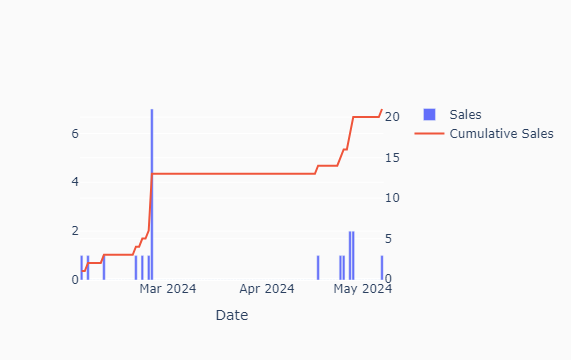

In [393]:
mint_to_sales_fig.update_layout(
    plot_bgcolor='#fafafa',
    paper_bgcolor='#fafafa',
)

listing_to_sales_fig.update_layout(
    plot_bgcolor='#fafafa',
    paper_bgcolor='#fafafa',
)

daily_box_mints_fig.update_layout(
    plot_bgcolor='#fafafa',
    paper_bgcolor='#fafafa',
)

daily_box_sales_fig.update_layout(
    plot_bgcolor='#fafafa',
    paper_bgcolor='#fafafa',
)

daily_vol_fig.update_layout(
    plot_bgcolor='#fafafa',
    paper_bgcolor='#fafafa',
)

daily_sales_fig.update_layout(
    plot_bgcolor='#fafafa',
    paper_bgcolor='#fafafa',
)



In [417]:
external_stylesheets = [
    'https://cdnjs.cloudflare.com/ajax/libs/normalize/8.0.1/normalize.min.css', 
    '/assets/styles.css'
]

app = Dash(__name__, external_stylesheets=external_stylesheets)

tts_markdown = f"""
Average Time to Sell a .box Domain: {avg_time_to_sell}
"""

listing_to_sale_mk = f"""Average Listing Price to Sale Price Change {listing_price_to_sale_avg_pct_change} """

cumulative_lts_mk = f"""Cumulative Listings to Sales Ratio: {round(int(cumulative_listings_to_sales), 0)}:1"""
cumulative_mts_mk = f"""Cumulative Mints to Sales Ratio: {round(int(cumulative_mint_to_sales),0)}:1"""
cum_sale_latest_mk = f"""Total Sales Volume: {cumulative_box_vol.iloc[-1]} """
max_sale_mk = f"""Highest Sold Domain: {max_eth_sale_row} """





# Define the layout of the app
app.layout = html.Div(style={'backgroundColor': 'var(--color-background)'}, children=[
    html.H1(children='.box Domains Dashboard', style={'textAlign': 'center', 'color': 'var(--wcm-color-fg-1)'}),
    html.Br(),
    html.H2('.box Domain Valuator', style={'color': 'var(--wcm-color-fg-2)'}),
    html.Div([
        "Input Domain Name: ",
        dcc.Input(id='valuator-input', value='example.box', type='text'),
        html.Button('Submit', id='submit-button', n_clicks=0)
    ], style={'color': 'var(--wcm-color-fg-1)'}),
    html.Br(),
    html.Div(id='valuator-output', style={'color': 'var(--wcm-color-fg-1)'}),
    html.Br(),
    html.H2('Key Metrics'),
    dcc.Markdown(children=tts_markdown, style={'color': 'var(--wcm-color-fg-2)'}),
    dcc.Markdown(children=listing_to_sale_mk, style={'color': 'var(--wcm-color-fg-2)'}),
    dcc.Markdown(children=cumulative_lts_mk, style={'color': 'var(--wcm-color-fg-2)'}),
    dcc.Markdown(children=cumulative_mts_mk, style={'color': 'var(--wcm-color-fg-2)'}),
    dcc.Graph(id='mint to sales', figure=mint_to_sales_fig),
    dcc.Graph(id='listings to sales', figure=listing_to_sales_fig),
    
    html.H2('Sales'),
    dcc.Markdown(children=cum_sale_latest_mk),
    dcc.Markdown(children=max_sale_mk),
    dcc.Graph(id='daily_sales_count', figure=daily_sales_fig),
    dcc.Graph(id='daily_sales_vol', figure=daily_vol_fig),
    dcc.Graph(id='daily_sales', figure=daily_box_sales_fig),
    html.Br(),
    html.H3('10 Latest Sales'),
    dash_table.DataTable(
        id='latest_sales',
        columns=[{"name": i, "id": i} for i in latest_box_domains_sales.columns],
        data=latest_box_domains_sales.to_dict('records'),
        style_table={'overflowX': 'auto'},
        style_cell={
            'height': 'auto',
            'minWidth': '150px', 'width': '150px', 'maxWidth': '150px',
            'whiteSpace': 'normal',
            'font-family': 'var(--font-primary, "Inter")',
            'backgroundColor': 'var(--color-background)',
            'color': 'var(--wcm-color-fg-2)'
        }
    ),
    
    html.Br(),
    html.H2('Mints'),
    dcc.Graph(id='daily_mints', figure=daily_box_mints_fig),
    html.Br(),
    html.H3('10 Latest Mints'),
    dash_table.DataTable(
        id='latest_mints',
        columns=[{"name": i, "id": i} for i in latest_box_domains_mints.columns],
        data=latest_box_domains_mints.to_dict('records'),
        style_table={'overflowX': 'auto'},
        style_cell={
            'height': 'auto',
            'minWidth': '150px', 'width': '150px', 'maxWidth': '150px',
            'whiteSpace': 'normal',
            'font-family': 'var(--font-primary, "Inter")',
            'backgroundColor': 'var(--color-background)',
            'color': 'var(--wcm-color-fg-2)'
        }
    ),
    
    
])

# Define the callback
@callback(
    Output(component_id='valuator-output', component_property='children'),
    Input(component_id='submit-button', component_property='n_clicks'),
    State(component_id='valuator-input', component_property='value')
)
def update_output_div(n_clicks, domain):
    if n_clicks == 0:
        return "Please enter a domain name and click Submit."
    
    if not domain:
        return "Please enter a domain name."
    
    domain_df = pd.DataFrame({'domain': [domain]})
    domain_processed = model_prep(domain_df)
    domain_value = value_domain(domain_processed)
    return f'Estimated Value: ${round(domain_value,2):,.2f}'

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)

predicted value: 1337.9181312187911
predicted value: 2560.052931522908
